<img src = "../imgs/Banner_Logo.jpeg"/>

## 1. Background substraction (BS)
BS algorithms **detect moving objects** from static cameras and separate the **foreground** from the **background**. The principle is very simple and intituive: 

- Select a reference frame: **the background**. This frame has the information of static pixels, average pixels or representative pixels along the video

- Then, we substract each frame w.r.t **the background frame**

<img src="../imgs/BS.png" style="width:700px">

**Widely used** because eficacy and real time perfomance: traffic monitoring, human action recognition, object tracking, biometry, among much others

**Go to the action!**


In [1]:
import cv2 as cv
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
def get_video(path):
    print("The video path is the following: {}".format(path))
    video = cv.VideoCapture(path)
    height = int(video.get(cv.CAP_PROP_FRAME_HEIGHT))
    width = int(video.get(cv.CAP_PROP_FRAME_WIDTH))
    frames = int(video.get(cv.CAP_PROP_FRAME_COUNT))
    channels = 1
    print ("The height of the video is: {} pixels".format(height))
    print ("The width of the video is: {} pixels".format(width))
    print ("The video has {} frames ".format(frames))
    print ("Each frame of the video has {} channels".format(channels))
    has_frame,current_frame = video.read()
    video_list = []
    while has_frame :
        current_frame = cv.cvtColor(current_frame, cv.COLOR_BGR2GRAY)
        video_list.append(current_frame)
        has_frame, current_frame = video.read()
    return video_list

In [3]:
def plot_frames_from_video(video, index):
    plt.figure(figsize=(8,8))
    plt.title("Frame {}".format(index))
    plt.imshow(video[index], cmap='gray')

In [4]:
video_path = "../videos/gait.mp4"
original_video = get_video(video_path)

interact(plot_frames_from_video, video = fixed(original_video), index = widgets.IntSlider(min=0, max = len(original_video)-1))

The video path is the following: ../videos/gait.mp4
The height of the video is: 211 pixels
The width of the video is: 480 pixels
The video has 609 frames 
Each frame of the video has 1 channels


aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0wLCBkZXNjcmlwdGlvbj11J2luZGV4JywgbWF4PTYwOCksIE91dHB1dCgpKSwgX2RvbV9jbGFzc2VzPSh1J3dpZGdldC1pbnTigKY=


<function __main__.plot_frames_from_video>

In [6]:
def create_directory(path):
    import os
    # define the name of the directory to be created
    gait_frames_path = path
    try:
        os.makedirs(gait_frames_path)
        print("=========================================================")
        print("The folder "+gait_frames_path+" was created sucessfully!")
        print("=========================================================")
    except Exception as e:
        print("=========================================================")
        print("There was an error creating the folder "+gait_frames_path+"\n message: "+str(e))
        print("=========================================================")
        

In [7]:
path = "frames/BS/"
create_directory(path)
path = "frames/BS2/"
create_directory(path)

The folder frames/BS/ was created sucessfully!
The folder frames/BS2/ was created sucessfully!


## Some approximations to the background 

Remember **The Holy Grail** is to model the **Background**

####  First approximation: Difference between a frame and an average frame 

The ideal background are the central value of a discrete set of numbers, i.e., the **mean**
* First, we compute the mean $\hat{B(x,y)} = \frac{1}{n}\sum_{t} I_{t}(x,y)$
* Then: $E_t(x,y) = \mid I_{t}(x,y) - \hat{B(x,y)} \mid$
*  $E_{t}(x,y) > \tau $, from a threshold $\tau$

$F_t(x,y) = \left\{\begin{matrix}
 255 & \text{ if } E_{t}(x,y) > \tau  \\ 
 0 & \text{elsewhere }
\end{matrix}\right.$



   
   

   
  
   
   
   * Finally we select a threshold: $E_{t}(x,y) > \tau $

In [8]:
def get_average_frame(path):
    print("The video path is the following: {}".format(path))
    video = cv.VideoCapture(path)
    height = int(video.get(cv.CAP_PROP_FRAME_HEIGHT))
    width = int(video.get(cv.CAP_PROP_FRAME_WIDTH))
    frames = int(video.get(cv.CAP_PROP_FRAME_COUNT))
    channels = 1
    print ("The height of the video is: {} ".format(height))
    print ("The width of the video is: {} ".format(width))
    print ("The video has {} frames ".format(frames))
    print ("Each frame of the video has {} channels".format(channels))
    frame_sum = np.zeros(shape=(height,width))
    has_frame,current_frame = video.read()
    current_frame = cv.cvtColor(current_frame, cv.COLOR_BGR2GRAY)

    while has_frame :
        frame_sum = frame_sum + current_frame
        has_frame, current_frame = video.read()     
        if(has_frame):
            current_frame = cv.cvtColor(current_frame, cv.COLOR_BGR2GRAY)

    frame_average = frame_sum/frames
    frame_average = frame_average.astype(np.uint8)
    plt.title("Background frame")
    plt.imshow(frame_average, cmap='gray');
    return frame_average

The video path is the following: ../videos/gait.mp4
The height of the video is: 211 
The width of the video is: 480 
The video has 609 frames 
Each frame of the video has 1 channels


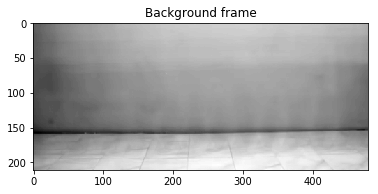

In [9]:
video_path = "../videos/gait.mp4"
frame_average = get_average_frame(video_path)

In [10]:
def get_background_substraction(path, frame_average, threshold = 10):
    print("The video path is the following: {}".format(path))
    video = cv.VideoCapture(path)
    height = int(video.get(cv.CAP_PROP_FRAME_HEIGHT))
    width = int(video.get(cv.CAP_PROP_FRAME_WIDTH))
    frames = int(video.get(cv.CAP_PROP_FRAME_COUNT))
    channels = 3
    print ("The height of the video is: {} ".format(height))
    print ("The width of the video is: {} ".format(width))
    print ("The video has {} frames ".format(frames))
    print ("Each frame of the video has {} channels".format(channels))
    video_BS = []
    has_frame,current_frame = video.read()
    frame_average = np.array(frame_average, np.float64)
    i = 0
    while (has_frame):
        current_frame = cv.cvtColor(current_frame, cv.COLOR_BGR2GRAY)
        current_frame = np.array(current_frame, np.float64)
        difference = cv.absdiff(frame_average, current_frame)
        th, difference_th = cv.threshold(difference, threshold, 255 , cv.THRESH_BINARY)
        #cv.imwrite( "{}/{}.png".format("frames/gait",i), current_frame)
        cv.imwrite( "{}/BS_1_{}.png".format("frames/BS",i), difference_th )
        video_BS.append(difference_th)
        print("The frame {} has been saved".format(i))
        i = i + 1
        has_frame, current_frame = video.read()
    return video_BS

In [11]:
video_path = "../videos/gait.mp4"
background_substraction_video = get_background_substraction(video_path, frame_average, 30)

The video path is the following: ../videos/gait.mp4
The height of the video is: 211 
The width of the video is: 480 
The video has 609 frames 
Each frame of the video has 3 channels
The frame 0 has been saved
The frame 1 has been saved
The frame 2 has been saved
The frame 3 has been saved
The frame 4 has been saved
The frame 5 has been saved
The frame 6 has been saved
The frame 7 has been saved
The frame 8 has been saved
The frame 9 has been saved
The frame 10 has been saved
The frame 11 has been saved
The frame 12 has been saved
The frame 13 has been saved
The frame 14 has been saved
The frame 15 has been saved
The frame 16 has been saved
The frame 17 has been saved
The frame 18 has been saved
The frame 19 has been saved
The frame 20 has been saved
The frame 21 has been saved
The frame 22 has been saved
The frame 23 has been saved
The frame 24 has been saved
The frame 25 has been saved
The frame 26 has been saved
The frame 27 has been saved
The frame 28 has been saved
The frame 29 has

The frame 300 has been saved
The frame 301 has been saved
The frame 302 has been saved
The frame 303 has been saved
The frame 304 has been saved
The frame 305 has been saved
The frame 306 has been saved
The frame 307 has been saved
The frame 308 has been saved
The frame 309 has been saved
The frame 310 has been saved
The frame 311 has been saved
The frame 312 has been saved
The frame 313 has been saved
The frame 314 has been saved
The frame 315 has been saved
The frame 316 has been saved
The frame 317 has been saved
The frame 318 has been saved
The frame 319 has been saved
The frame 320 has been saved
The frame 321 has been saved
The frame 322 has been saved
The frame 323 has been saved
The frame 324 has been saved
The frame 325 has been saved
The frame 326 has been saved
The frame 327 has been saved
The frame 328 has been saved
The frame 329 has been saved
The frame 330 has been saved
The frame 331 has been saved
The frame 332 has been saved
The frame 333 has been saved
The frame 334 

The frame 602 has been saved
The frame 603 has been saved
The frame 604 has been saved
The frame 605 has been saved
The frame 606 has been saved
The frame 607 has been saved
The frame 608 has been saved


In [12]:

    
interact_manual(plot_frames_from_video, video = fixed(background_substraction_video),
                 index  = widgets.IntSlider(min=0, max = len(background_substraction_video)-1))
interact(plot_frames_from_video, video = fixed(background_substraction_video),
                 index  = widgets.IntSlider(min=0, max = len(background_substraction_video)-1))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0wLCBkZXNjcmlwdGlvbj11J2luZGV4JywgbWF4PTYwOCksIEJ1dHRvbihkZXNjcmlwdGlvbj11J1J1biBJbnRlcmFjdCcsIHPigKY=


aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0wLCBkZXNjcmlwdGlvbj11J2luZGV4JywgbWF4PTYwOCksIE91dHB1dCgpKSwgX2RvbV9jbGFzc2VzPSh1J3dpZGdldC1pbnTigKY=


<function __main__.plot_frames_from_video>

### Second approximation: Difference between consecutive frames 

The idea is to derivate but temporally among sequence of frames.

$F_t(x,y) = \left\{\begin{matrix}
 255 & \text{ if } |I_t -I_{t-1}| > \tau  \\ 
 0 & \text{elsewhere }
\end{matrix}\right.$

In [13]:
def get_background_substraction2 (original_video, threshold):
    video_BS = []
    for i in range (len(original_video)-1):
        current_frame = original_video[i]
        next_frame = original_video[i+1]
        difference = cv.absdiff(next_frame, current_frame)
        th, difference_th = cv.threshold(difference, threshold, 255 , cv.THRESH_BINARY)
        cv.imwrite( "{}/BS_1_{}.png".format("frames/BS2",i), difference_th )
        video_BS.append(difference_th)
        print("The frame {} has been saved".format(i))
    return video_BS

In [14]:
background_substraction_video2 = get_background_substraction2(original_video,30)

The frame 0 has been saved
The frame 1 has been saved
The frame 2 has been saved
The frame 3 has been saved
The frame 4 has been saved
The frame 5 has been saved
The frame 6 has been saved
The frame 7 has been saved
The frame 8 has been saved
The frame 9 has been saved
The frame 10 has been saved
The frame 11 has been saved
The frame 12 has been saved
The frame 13 has been saved
The frame 14 has been saved
The frame 15 has been saved
The frame 16 has been saved
The frame 17 has been saved
The frame 18 has been saved
The frame 19 has been saved
The frame 20 has been saved
The frame 21 has been saved
The frame 22 has been saved
The frame 23 has been saved
The frame 24 has been saved
The frame 25 has been saved
The frame 26 has been saved
The frame 27 has been saved
The frame 28 has been saved
The frame 29 has been saved
The frame 30 has been saved
The frame 31 has been saved
The frame 32 has been saved
The frame 33 has been saved
The frame 34 has been saved
The frame 35 has been saved
Th

The frame 314 has been saved
The frame 315 has been saved
The frame 316 has been saved
The frame 317 has been saved
The frame 318 has been saved
The frame 319 has been saved
The frame 320 has been saved
The frame 321 has been saved
The frame 322 has been saved
The frame 323 has been saved
The frame 324 has been saved
The frame 325 has been saved
The frame 326 has been saved
The frame 327 has been saved
The frame 328 has been saved
The frame 329 has been saved
The frame 330 has been saved
The frame 331 has been saved
The frame 332 has been saved
The frame 333 has been saved
The frame 334 has been saved
The frame 335 has been saved
The frame 336 has been saved
The frame 337 has been saved
The frame 338 has been saved
The frame 339 has been saved
The frame 340 has been saved
The frame 341 has been saved
The frame 342 has been saved
The frame 343 has been saved
The frame 344 has been saved
The frame 345 has been saved
The frame 346 has been saved
The frame 347 has been saved
The frame 348 

The frame 606 has been saved
The frame 607 has been saved


In [15]:
interact_manual(plot_frames_from_video, video = fixed(background_substraction_video2),
                 index  = widgets.IntSlider(min=0, max = len(background_substraction_video)-1))
interact(plot_frames_from_video, video = fixed(background_substraction_video2),
                 index  = widgets.IntSlider(min=0, max = len(background_substraction_video)-1))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0wLCBkZXNjcmlwdGlvbj11J2luZGV4JywgbWF4PTYwOCksIEJ1dHRvbihkZXNjcmlwdGlvbj11J1J1biBJbnRlcmFjdCcsIHPigKY=


aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0wLCBkZXNjcmlwdGlvbj11J2luZGV4JywgbWF4PTYwOCksIE91dHB1dCgpKSwgX2RvbV9jbGFzc2VzPSh1J3dpZGdldC1pbnTigKY=


<function __main__.plot_frames_from_video>

<img src="../imgs/bannerThanks.jpg" style="width:1000px;">